<a href="https://colab.research.google.com/github/Konstantinosil/Chortareas-Linardatos-Central-Bank-Credibility-in-Comparative-Perspective-Framework-and-Evidence/blob/main/What_Determines_Central_Banks'_Credibility_at_the_ELB%3F_Chortareas_%26_Linardatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, re, warnings, random, math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm, t as student_t

warnings.filterwarnings("ignore")

ROOT = "/content"
if not os.path.exists(os.path.join(ROOT, "chapter 2.xlsx")):
    ROOT = "/mnt/data"

OUTDIR = "/mnt/data" if os.path.isdir("/mnt/data") else ROOT
os.makedirs(OUTDIR, exist_ok=True)
def _p(fn):
    return os.path.join(OUTDIR, fn)

SAVE_FILES = False

XLS_MAIN = os.path.join(ROOT, "chapter 2.xlsx")
TEXT_US  = os.path.join(ROOT, "text data us.xlsx")
TEXT_EU  = os.path.join(ROOT, "text data eu.xlsx")
TEXT_UK  = os.path.join(ROOT, "text data uk.xlsx")

START = pd.Timestamp("2008-01-01")
END   = pd.Timestamp("2022-12-31")

PI_STAR = 2.0
R_STAR  = 1.0

PHI_PI_DEFAULT = 1.5
PHI_Y_DEFAULT  = 0.5
RHO_DEFAULT    = 0.8
HAC_LAGS_BASE  = 6
ELB_EPS        = 0.10

ELB_THRESHOLDS = {"ECB": 0.10, "BoE": 0.25, "Fed": 0.25}

np.random.seed(123)
random.seed(123)

def freq_audit(xls_path):
    try:
        xls = pd.ExcelFile(xls_path)
    except Exception as e:
        print(f"[freq_audit] Cannot open {xls_path}: {e}")
        return
    print("\n" + "="*120)
    print(f"Frequency audit of {xls_path}")
    print("="*120)
    for sh in xls.sheet_names:
        d = pd.read_excel(xls_path, sheet_name=sh)
        if "Date" not in d.columns:
            print(f"{sh:35s} n={len(d):4d} freq≈None")
            continue
        dd = d.copy()
        dd["Date"] = pd.to_datetime(dd["Date"], errors="coerce")
        dd = dd.dropna(subset=["Date"]).sort_values("Date")
        try:
            freq = pd.infer_freq(dd["Date"])
        except:
            freq = None
        print(f"{sh:35s} n={len(dd):4d} freq≈{str(freq) or 'None'}")

def smooth_series(s, rho=RHO_DEFAULT):
    s = pd.to_numeric(s, errors="coerce")
    out=[]; prev=np.nan
    for x in s.values:
        if np.isnan(prev) or np.isnan(x) or rho==0.0:
            out.append(x); prev=x
        else:
            val = (1-rho)*x + rho*prev
            out.append(val); prev=val
    return pd.Series(out, index=s.index)

def winsorize(df, cols, p=0.01):
    z = df.copy()
    for c in cols:
        if c in z:
            lo, hi = z[c].quantile([p, 1-p])
            z[c] = z[c].clip(lo, hi)
    return z

def robust_z(x):
    x = pd.to_numeric(x, errors="coerce")
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if not np.isfinite(mad) or mad == 0:
        mu = np.nanmean(x); sd = np.nanstd(x, ddof=1)
        return (x - mu) / (sd if (sd and np.isfinite(sd)) else 1.0)
    return (x - med) / (1.4826 * mad)

def bh_fdr(pvals):
    p = np.asarray(pvals, dtype=float)
    n = len(p); order = np.argsort(p); ranked = p[order]
    q = np.empty_like(ranked)
    prev = 1.0
    for i in range(n-1, -1, -1):
        q[i] = min(prev, ranked[i] * n / (i+1))
        prev = q[i]
    qfull = np.empty_like(q); qfull[order] = q
    return qfull

def params_as_series(res):
    return pd.Series(res.params, index=res.model.exog_names).astype(float)

def bse_as_series(res):
    return pd.Series(res.bse, index=res.model.exog_names).astype(float)

def pvalues_as_series(res):
    return pd.Series(res.pvalues, index=res.model.exog_names).astype(float)

def safe_get_triplet(res, name):
    b = params_as_series(res)
    se = bse_as_series(res)
    pv = pvalues_as_series(res)
    return float(b.get(name, np.nan)), float(se.get(name, np.nan)), float(pv.get(name, np.nan))

def merge_no_overlap(left, right, on, suffix="_r", how="left", validate=None):
    on = list(on)
    overlap = (set(left.columns) & set(right.columns)) - set(on)
    r = right.rename(columns={c: f"{c}{suffix}" for c in overlap})
    return left.merge(r, on=on, how=how, validate=validate)

def read_block(sheet, bank, value_col):
    d = pd.read_excel(XLS_MAIN, sheet_name=sheet)
    d = d.rename(columns={"Date":"date", value_col:value_col})
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    x = pd.to_numeric(d[value_col], errors="coerce")
    if x.notna().mean() < 0.5:
        raw = d[value_col].astype(str)
        x = (raw
             .str.replace("%","", regex=False)
             .str.replace("\u2212","-", regex=False)
             .str.replace(" ", "", regex=False)
             .str.replace(",", ".", regex=False))
        x = pd.to_numeric(x, errors="coerce")
        d[value_col] = x
    d["bank"] = bank
    return d[["date","bank", value_col]].sort_values("date")

def read_all():
    eu_pol = read_block("Policy Rates EU","ECB","POLICY")
    eu_inf = read_block("Inflation EU","ECB","INF")
    eu_vol = read_block("Volatility EU","ECB","VOL")
    eu_gdp = read_block("RGDP EU","ECB","GDP")
    eu_cli = read_block("Composite Leader Indicator EU","ECB","CLI")

    uk_pol = read_block("Policy Rates UK","BoE","POLICY")
    uk_inf = read_block("Inflation UK","BoE","INF")
    uk_vol = read_block("Volatility UK","BoE","VOL")
    uk_gdp = read_block("RGDP UK","BoE","GDP")
    uk_cli = read_block("Composite Leader Indicator UK","BoE","CLI")

    us_pol = read_block("Policy Rates US","Fed","POLICY")
    us_inf = read_block("Inflation US","Fed","INF")
    us_vol = read_block("Volatility US","Fed","VOL")
    us_gdp = read_block("RGDP US","Fed","GDP")
    us_cli = read_block("Composite Leader Indicator US","Fed","CLI")

    pol = pd.concat([eu_pol, uk_pol, us_pol], ignore_index=True)
    inf = pd.concat([eu_inf, uk_inf, us_inf], ignore_index=True)
    vol = pd.concat([eu_vol, uk_vol, us_vol], ignore_index=True)
    gdp = pd.concat([eu_gdp, uk_gdp, us_gdp], ignore_index=True)
    cli = pd.concat([eu_cli, uk_cli, us_cli], ignore_index=True)
    return pol, inf, vol, gdp, cli

def hamilton_output_gap(log_gdp, k=12):
    y = pd.to_numeric(log_gdp, errors="coerce")
    Xlags = pd.concat([y.shift(i) for i in range(1, k+1)], axis=1)
    Xlags.columns = [f"lag{i}" for i in range(1, k+1)]
    resid = pd.Series(index=y.index, dtype=float)
    for t in range(k+8, len(y)):
        X_t = sm.add_constant(Xlags.iloc[:t].dropna())
        idx = X_t.index
        y_t = y.loc[idx]
        if len(y_t) >= k + 5:
            beta = sm.OLS(y_t, X_t).fit().params
            row = sm.add_constant(Xlags.iloc[t:t+1]).iloc[0]
            y_hat = float((row * beta.reindex(row.index).fillna(0)).sum())
            resid.iloc[t] = y.iloc[t] - y_hat
    return resid * 100.0

def to_monthly_panel(elb_eps=ELB_EPS, rho=RHO_DEFAULT, elb_mode="data_driven"):
    pol, inf, vol, gdp, cli = read_all()

    def infer_yoy_from_INF(series):
        s = pd.to_numeric(series, errors="coerce")
        med = s.median()
        return s.pct_change(12, fill_method=None)*100.0 if (np.isfinite(med) and med>30) else s

    res=[]
    for b in ["ECB","BoE","Fed"]:
        gpol = pol[pol["bank"]==b].set_index("date").sort_index()
        m_pol = gpol["POLICY"].resample("ME").last()

        gvol = vol[vol["bank"]==b].set_index("date").sort_index()
        m_vol = gvol["VOL"].resample("ME").mean()

        ginf = inf[inf["bank"]==b].set_index("date").sort_index()
        m_inf = ginf["INF"].resample("ME").last()
        m_infl_yoy = infer_yoy_from_INF(m_inf)

        gcli = cli[cli["bank"]==b].set_index("date").sort_index()
        m_cli = gcli["CLI"].resample("ME").last()

        ggdp = gdp[gdp["bank"]==b].copy()
        ggdp["GDP"] = pd.to_numeric(ggdp["GDP"], errors="coerce")
        ggdp = ggdp.set_index("date").sort_index()
        q_end = ggdp.copy(); q_end.index = q_end.index.to_period("Q").to_timestamp("Q")
        m_gdp = q_end["GDP"].resample("M").interpolate("linear").resample("ME").last()

        mm = pd.concat([m_pol, m_vol, m_infl_yoy, m_cli, m_gdp], axis=1)
        mm.columns = ["policy_rate","volatility","infl_yoy","cli","gdp"]
        mm["bank"]=b
        mm = mm.reset_index().rename(columns={"index":"date"})
        res.append(mm)

    mon = pd.concat(res, ignore_index=True)
    mon = mon[(mon["date"]>=START) & (mon["date"]<=END)].copy()
    mon = mon.sort_values(["bank","date"])

    outs=[]
    for b, g in mon.groupby("bank", sort=False):
        gg = g.copy()
        gg["gdp"] = pd.to_numeric(gg["gdp"], errors="coerce").ffill().bfill()
        gg["log_gdp"] = np.log(gg["gdp"])
        gg["output_gap"] = hamilton_output_gap(gg["log_gdp"], k=12)
        outs.append(gg)
    mon = pd.concat(outs, ignore_index=True)

    mon["inflation_gap"] = pd.to_numeric(mon["infl_yoy"], errors="coerce") - PI_STAR

    mon["year"]  = mon["date"].dt.year
    mon["month"] = mon["date"].dt.month
    mon["ym"]    = mon["date"].dt.to_period("M")
    mon["mnum"]  = mon["ym"].astype(int)

    mon["crisis10"] = mon["year"].between(2010, 2012).astype(int)
    mon["pandem"]   = mon["year"].between(2020, 2021).astype(int)

    def qe_flag(b, y):
        if pd.isna(y): return 0
        y=int(y)
        if b=="ECB": return int((2015<=y<=2018) or (2020<=y<=2021))
        if b=="BoE": return int((2009<=y<=2012) or (2020<=y<=2021))
        if b=="Fed": return int((2009<=y<=2014) or (2020<=y<=2021))
        return 0
    mon["QE_FG"] = mon.apply(lambda r: qe_flag(r["bank"], r["year"]), axis=1).astype(int)

    def elb_data_driven_series(s, eps=ELB_EPS):
        s = pd.to_numeric(s, errors="coerce")
        roll_min = s.rolling(24, min_periods=6).min()
        return (s <= (roll_min + eps)).astype(int)

    if elb_mode == "data_driven":
        mon["ELB"] = mon.groupby("bank", group_keys=False)["policy_rate"].apply(lambda s: elb_data_driven_series(s, eps=elb_eps)).astype(int)
    elif elb_mode == "fixed":
        mon["ELB"] = mon.apply(lambda r: int(r["policy_rate"] <= ELB_THRESHOLDS.get(str(r["bank"]), 0.25)), axis=1).astype(int)
    else:
        raise ValueError("elb_mode must be 'data_driven' or 'fixed'")

    mon["policy_rate_lead3"] = mon.groupby("bank")["policy_rate"].shift(-3)
    mon["di"] = mon.groupby("bank")["policy_rate"].diff()
    mon["abs_deltai_3m"] = (mon["policy_rate_lead3"] - mon["policy_rate"]).abs()
    mon["abs_deltai_3m_lag"] = mon.groupby("bank")["abs_deltai_3m"].shift(1)

    mon["abs_pi_gap"] = (mon["inflation_gap"]).abs()
    mon["abs_y_gap"]  = (mon["output_gap"]).abs()
    denom = mon["abs_pi_gap"] + mon["abs_y_gap"]
    mon["pi_share"] = np.where(denom>0, mon["abs_pi_gap"]/denom, np.nan)

    mon["cli_z"] = mon.groupby("bank")["cli"].transform(lambda s: (s - s.mean())/s.std())
    mon["volatility_z"] = mon.groupby("bank")["volatility"].transform(lambda s: (s - s.mean())/s.std())

    return mon

def estimate_reaction_function_realtime(mon, window=60, sample_mask=None):
    Z = ["inflation_gap","output_gap","ELB","QE_FG","crisis10","pandem","di_lag"]
    out=[]
    for b, g in mon.sort_values(["bank","date"]).groupby("bank"):
        z = g.copy()
        z["di_lag"] = z["di"].shift(1)
        z = z.dropna(subset=["di"]+Z)
        if z.empty:
            continue
        names=["const"]+Z
        di_hat = []
        for i in range(len(z)):
            lo=max(0, i-window)
            sub=z.iloc[lo:i]
            if sample_mask is not None:
                idx_ok = sample_mask.loc[sub.index] if isinstance(sample_mask, pd.Series) else sample_mask
                sub = sub.loc[idx_ok]
            if len(sub) < max(24, len(Z)+5):
                di_hat.append(np.nan); continue
            X = pd.DataFrame({"const":1.0}, index=sub.index)
            for c in Z: X[c]=pd.to_numeric(sub[c], errors="coerce").astype(float)
            res = sm.OLS(pd.to_numeric(sub["di"], errors="coerce").astype(float), X).fit()
            x_now = pd.Series({"const":1.0}, dtype=float)
            for c in Z: x_now[c]=float(z.iloc[i][c])
            di_hat.append(float((x_now[names] * res.params.reindex(names).fillna(0)).sum()))
        z["di_hat_rt"] = di_hat
        z["di_surpr_rt"] = z["di"] - z["di_hat_rt"]
        out.append(z[["date","bank","di_hat_rt","di_surpr_rt"]])
    if not out:
        return pd.DataFrame(columns=["date","bank","di_hat_rt","di_surpr_rt"])
    return pd.concat(out, ignore_index=True)

def cond_var_surprise_rt(mon, span=12):
    out=[]
    for b,g in mon.sort_values(["bank","date"]).groupby("bank"):
        z=g.copy()
        z["sv_ewm_rt"]=pd.to_numeric(z["di_surpr_rt"], errors="coerce").ewm(span=span, min_periods=6).var(bias=False)
        out.append(z[["date","bank","sv_ewm_rt"]])
    return pd.concat(out, ignore_index=True)

def build_surprise_h_rt(mon, h=3):
    z = mon.sort_values(["bank","date"]).copy()
    if "di_surpr_rt" not in z.columns:
        raise ValueError("Missing di_surpr_rt for horizon calc.")
    z[f"cum_surpr_{h}_rt"] = z.groupby("bank")["di_surpr_rt"].transform(lambda s: s.shift(-1).rolling(h, min_periods=h).sum())
    z[f"abs_surprise_rel_{h}_rt"] = z[f"cum_surpr_{h}_rt"].abs()
    return z

def rf_params_rt(mon, window=60):
    Z = ["inflation_gap","output_gap","ELB","QE_FG","crisis10","pandem","di_lag"]
    out=[]
    for b, g in mon.sort_values(["bank","date"]).groupby("bank"):
        z = g.copy()
        z["di_lag"] = z["di"].shift(1)
        z = z.dropna(subset=["di"]+Z)
        phi_pi=[]; phi_y=[]
        for i in range(len(z)):
            lo=max(0, i-window)
            sub=z.iloc[lo:i]
            if len(sub)<max(24, len(Z)+5):
                phi_pi.append(np.nan); phi_y.append(np.nan)
                continue
            X=pd.DataFrame({"const":1.0}, index=sub.index)
            for c in Z: X[c]=pd.to_numeric(sub[c], errors="coerce").astype(float)
            params=sm.OLS(pd.to_numeric(sub["di"], errors="coerce").astype(float), X).fit().params
            phi_pi.append(float(params.get("inflation_gap", np.nan)))
            phi_y.append( float(params.get("output_gap", np.nan)))
        tmp=z[["date"]].copy()
        tmp["bank"]=b
        tmp["phi_pi_rt"]=phi_pi
        tmp["phi_y_rt"]=phi_y
        tmp["omega_t_rt"]=np.abs(tmp["phi_pi_rt"])/(np.abs(tmp["phi_pi_rt"])+np.abs(tmp["phi_y_rt"]))
        out.append(tmp[["date","bank","phi_pi_rt","phi_y_rt","omega_t_rt"]])
    return pd.concat(out, ignore_index=True)

_VOWELS = "aeiouy"
NEGATIONS = set("not no never neither nor nothing none nobody nowhere cannot can't wont won't shouldn't wouldn't couldn't".split())
HEDGES=set("may might could would should possibly perhaps likely unlikely around approximately roughly broadly somewhat nearly about around".split())
MODALS=set(["may","might","could","would","should"])
NEG_MODAL_PHRASES = [
    "may not","might not","could not","couldn't","would not","wouldn't","should not","shouldn't",
    "cannot","can't","will not","won't","did not","didn't","do not","don't"
]
JARGON = set("""accommodation accommodative forward guidance asset purchases quantitative easing qe qt taper liftoff tightening easing reinvestment balance-sheet balance sheet term premium ioer ior corridor floor standing facility repo reverse repo rrp ample reserves neutral rate r* r-star natural rate phillips curve output gap potential output slack transitory persistence inflation expectations anchoring de-anchoring headline core trimmed mean supercore breakeven t-bill t-bonds notes ois swap shadow rate term structure expectations hypothesis""".split())

def sent_split(t):
    return [s.strip() for s in re.split(r"[.!?]+", t) if s.strip()]

def count_syllables(word):
    w = re.sub(r"[^a-z]", "", word.lower())
    if not w: return 0
    syl = 0; prev_v = False
    for ch in w:
        isv = ch in _VOWELS
        if isv and not prev_v: syl += 1
        prev_v = isv
    if w.endswith("e") and syl>1: syl -= 1
    return max(syl,1)

def readability_scores(text):
    t = re.sub(r"\s+"," ",str(text)).strip()
    sents = [s for s in re.split(r"[.!?]+", t) if s.strip()]
    words = re.findall(r"[A-Za-z']+", t)
    n_s = max(len(sents),1); n_w = max(len(words),1)
    n_sy = sum(count_syllables(w) for w in words)
    fre = 206.835 - 1.015*(n_w/n_s) - 84.6*(n_sy/n_w)
    return fre, n_w, n_s

def approx_is_vbn(token):
    irr = {"been","done","made","seen","known","given","taken","built","sold","found","kept","held","led","left","read"}
    t = token.lower()
    return t in irr or t.endswith("ed")

def passive_voice_ratio(tokens):
    be_aux = {"is","are","was","were","be","been","being","am","'s","'re","'m"}
    count = 0
    for i,t in enumerate(tokens[:-1]):
        if t.lower() in be_aux and approx_is_vbn(tokens[i+1]):
            count += 1
    return count

def text_features(text):
    t = re.sub(r"\s+"," ",str(text)).strip()
    sents = sent_split(t)
    toks = re.findall(r"[A-Za-z']+", t)
    toks_l = [w.lower() for w in toks]
    n_s = max(len(sents),1); n_w = max(len(toks),1)
    fre, _, _ = readability_scores(t)
    avg_sent_len = n_w / n_s
    avg_word_len = np.mean([len(w) for w in toks]) if toks else 0.0
    hedge_share = sum(1 for w in toks_l if w in HEDGES)/n_w
    modal_share = sum(1 for w in toks_l if w in MODALS)/n_w
    negation_share = sum(1 for w in toks_l if w in NEGATIONS)/n_w
    tl = t.lower()
    neg_modal_hits = sum(tl.count(ph) for ph in NEG_MODAL_PHRASES)
    neg_modal_density = neg_modal_hits / n_s
    pv_per_sent = passive_voice_ratio(toks) / n_s
    jargon_share = sum(1 for w in toks_l if w in JARGON)/n_w
    return pd.Series({
        "FRE": fre,
        "avg_sentence_len": avg_sent_len,
        "avg_word_len": avg_word_len,
        "hedge_ratio": hedge_share,
        "modal_share": modal_share,
        "negation_share": negation_share,
        "neg_modal_density": neg_modal_density,
        "passive_per_sent": pv_per_sent,
        "jargon_share": jargon_share
    })

def load_text_corpora():
    rows=[]
    if os.path.exists(TEXT_EU):
        df = pd.read_excel(TEXT_EU, sheet_name="Eurozone", parse_dates=["Date"]).rename(columns={"Date":"event_date"})
        df["bank"]="ECB"; df["cat2"]="DEC"
        rows.append(df[["event_date","bank","Text"] + (["Title"] if "Title" in df.columns else [])])
    if os.path.exists(TEXT_UK):
        df = pd.read_excel(TEXT_UK, sheet_name="UK", parse_dates=["Date"]).rename(columns={"Date":"event_date"})
        df["bank"]="BoE"; df["cat2"]="MIN"
        rows.append(df[["event_date","bank","Text"] + (["Title"] if "Title" in df.columns else [])])
    if os.path.exists(TEXT_US):
        df = pd.read_excel(TEXT_US, sheet_name="US", parse_dates=["Date"]).rename(columns={"Date":"event_date"})
        df["bank"]="Fed"
        if "Title" not in df.columns: df["Title"]=""
        if "Text"  not in df.columns: df["Text"]=""
        def classify_us(title, txt):
            s = (str(title)+" "+str(txt)).lower()
            if "minutes" in s: return "MIN"
            if any(k in s for k in ["press conference","policy statement","post-meeting","post meeting",
                                    "meeting of the fomc","fomc meeting","fomc statement",
                                    "statement on monetary policy","conference call"]):
                return "DEC"
            if "statement" in s: return "DEC"
            return "OTHER"
        df["cat2"] = df.apply(lambda r: classify_us(r.get("Title",""), r.get("Text","")), axis=1)
        rows.append(df[["event_date","bank","Text","Title","cat2"]])
    if not rows: return None

    ev = pd.concat(rows, ignore_index=True)
    if "Title" not in ev.columns: ev["Title"]=""
    if "cat2"  not in ev.columns: ev["cat2"]="OTHER"
    ev["event_date"] = pd.to_datetime(ev["event_date"], errors="coerce")
    ev = ev.dropna(subset=["event_date","bank","Text"]).sort_values(["bank","event_date"])
    ev["ym"] = ev["event_date"].dt.to_period("M")
    ev = ev[(ev["event_date"]>=START) & (ev["event_date"]<=END)].copy()
    return ev

def features_and_clarity_pca(ev):
    f = ev["Text"].apply(text_features)
    z = pd.concat([ev[["event_date","bank","ym","cat2","Title","Text"]].reset_index(drop=True),
                   f.reset_index(drop=True)], axis=1)
    feat_cols = ["FRE","avg_sentence_len","avg_word_len","hedge_ratio","modal_share",
                 "negation_share","neg_modal_density","passive_per_sent","jargon_share"]
    for c in feat_cols:
        z[c+"_rz"] = z.groupby(["bank","cat2"], group_keys=False)[c].transform(robust_z)
    X = z[[c+"_rz" for c in feat_cols]].astype(float).values
    Xc = X - np.nanmean(X, axis=0, keepdims=True)
    Xc = np.nan_to_num(Xc, nan=0.0)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    pc1 = U[:,0]*S[0]
    fre_rz = np.nan_to_num(z["FRE_rz"].astype(float).values, nan=0.0)
    corr = np.corrcoef(pc1, fre_rz)[0,1]
    if np.isfinite(corr) and corr < 0: pc1 = -pc1
    sd = np.nanstd(pc1, ddof=1); mu = np.nanmean(pc1)
    z["Clarity_PC1"] = (pc1 - mu) / (sd if (sd and np.isfinite(sd)) else 1.0)
    return z, feat_cols

def build_P2_event_panel(mon):
    ev = load_text_corpora()
    if ev is None:
        print("[P2] No text corpora detected — skipping P2.")
        return None, None, None
    feats, feat_cols = features_and_clarity_pca(ev)
    feats["year"]  = feats["event_date"].dt.year
    feats["month"] = feats["event_date"].dt.month

    mm = mon.copy()
    mm["ym"] = mm["date"].dt.to_period("M")
    keep_cols = ["bank","ym","date","ELB","QE_FG","inflation_gap","cli_z","policy_rate","sv_ewm_rt"]
    if "abs_surprise_1m_rt" in mm.columns: keep_cols.append("abs_surprise_1m_rt")
    mkeep = mm[keep_cols].drop_duplicates(subset=["bank","ym"]).rename(columns={"date":"month_date"})

    p2 = feats.merge(mkeep, on=["bank","ym"], how="left")
    cnt = p2.groupby(["bank","ym"]).size().rename("n_events").reset_index()
    p2 = p2.merge(cnt, on=["bank","ym"], how="left")
    p2["w"] = 1.0

    p2 = p2.sort_values(["bank","event_date"])
    p2["abs_d_policy"] = p2.groupby("bank")["policy_rate"].diff().abs()
    p2["cli_z"] = p2.groupby("bank")["cli_z"].transform(lambda s: (s - s.mean())/s.std())

    p2["MIN"]   = (p2["cat2"]=="MIN").astype(int)
    p2["OTHER"] = (p2["cat2"]=="OTHER").astype(int)

    clarity_vars = ["Clarity_PC1"]
    for cvar in clarity_vars:
        p2[f"{cvar}_MIN"] = p2[cvar]*p2["MIN"]
        p2[f"{cvar}_OTHER"] = p2[cvar]*p2["OTHER"]
        p2[f"{cvar}_x_ELB"] = p2[cvar]*p2["ELB"]
        p2[f"{cvar}_x_ELB_x_MIN"] = p2[cvar]*p2["ELB"]*p2["MIN"]

    p2["BigMove"] = 0
    for b, g in p2.groupby("bank"):
        thr = g["abs_d_policy"].quantile(0.75)
        p2.loc[g.index, "BigMove"] = (g["abs_d_policy"] >= thr).astype(int)
    p2["MIN_x_BigMove"] = p2["MIN"]*p2["BigMove"]

    p2["use_y"] = p2["abs_surprise_1m_rt"]
    return p2, clarity_vars, "use_y"

def fe_ols(y, X, data, bank_fe=True, year_fe=False, month_fe=False, bank_year_fe=False,
           cov="HAC", hac_lags=None, weights=None):
    if bank_year_fe:
        bank_fe = False

    z = data.copy()

    X_df = pd.DataFrame(index=z.index)
    X_df["const"] = 1.0
    for name in X:
        X_df[name] = pd.to_numeric(z[name], errors="coerce")

    if bank_fe and "bank" in z:
        d = pd.get_dummies(z["bank"], prefix="", prefix_sep="", drop_first=True)
        d = d.apply(pd.to_numeric, errors="coerce").astype(float)
        X_df = pd.concat([X_df, d], axis=1)

    if bank_year_fe and "year" in z and "bank" in z:
        by = z["bank"].astype(str) + "_" + z["year"].astype(str)
        d = pd.get_dummies(by, prefix="by", drop_first=True).astype(float)
        X_df = pd.concat([X_df, d], axis=1)
    else:
        if year_fe and "year" in z:
            d = pd.get_dummies(z["year"], prefix="y", drop_first=True).astype(float)
            X_df = pd.concat([X_df, d], axis=1)

    if month_fe and "month" in z:
        d = pd.get_dummies(z["month"], prefix="m", drop_first=True).astype(float)
        X_df = pd.concat([X_df, d], axis=1)

    X_df = X_df.apply(pd.to_numeric, errors="coerce")
    X_df = X_df.replace([np.inf, -np.inf], np.nan)
    X_df = X_df.loc[:, X_df.notna().any(axis=0)]

    yv = pd.to_numeric(z[y], errors="coerce").replace([np.inf, -np.inf], np.nan)

    mask = yv.notna() & X_df.notna().all(axis=1)
    X_df = X_df.loc[mask].astype(float)
    yv   = yv.loc[mask].astype(float)

    if X_df.empty or yv.empty:
        raise ValueError("Empty design after NA drop.")

    w = None
    if weights is not None:
        w = pd.Series(weights, index=z.index).astype(float).loc[mask].fillna(1.0).values
    elif "w" in z.columns:
        w = pd.to_numeric(z["w"], errors="coerce").loc[mask].fillna(1.0).values

    if w is not None:
        res = sm.WLS(yv, X_df, weights=w).fit(
            cov_type=("HAC" if cov=="HAC" else "nonrobust"),
            cov_kwds={"maxlags": (hac_lags or 6)} if cov=="HAC" else None
        )
    else:
        res = sm.OLS(yv, X_df).fit(
            cov_type=("HAC" if cov=="HAC" else "nonrobust"),
            cov_kwds={"maxlags": (hac_lags or 6)} if cov=="HAC" else None
        )
    res._index = X_df.index.copy()
    return res

def twoway_cluster_se(res_ols, groups1, groups2):
    g1 = pd.Series(groups1).astype(str)
    g2 = pd.Series(groups2).astype(str)
    g1 = g1.loc[res_ols._index]
    g2 = g2.loc[res_ols._index]
    g12 = g1 + "×" + g2

    r1 = res_ols.get_robustcov_results(cov_type='cluster', groups=g1)
    r2 = res_ols.get_robustcov_results(cov_type='cluster', groups=g2)
    r12= res_ols.get_robustcov_results(cov_type='cluster', groups=g12)
    names = res_ols.model.exog_names
    k = len(names)
    def fix(A):
        A = np.asarray(A, dtype=float)
        if A.shape != (k, k): A = np.resize(A, (k, k))
        return A
    C1 = fix(r1.cov_params()); C2 = fix(r2.cov_params()); C12= fix(r12.cov_params())
    cov_tw = C1 + C2 - C12
    cov_tw = pd.DataFrame(cov_tw, index=names, columns=names)
    se = np.sqrt(np.maximum(np.diag(cov_tw), 0.0))
    se = pd.Series(se, index=names, name="se")
    params = params_as_series(res_ols)
    t = params / se.replace(0.0, np.nan)
    p = pd.Series(2 * (1 - norm.cdf(np.abs(t.values))), index=names, name="p")
    return {"se": se, "t": t, "p": p}

def wild_cluster_bootstrap_pvalue(X, y, w, res, groups, param_name, B=499, seed=123):
    rng = np.random.default_rng(seed)
    groups = pd.Series(groups).astype(str)
    groups = groups.loc[res._index].reset_index(drop=True)
    uniq = groups.unique()
    names = res.model.exog_names
    if param_name not in names: return np.nan
    idx = names.index(param_name)
    yhat = X @ res.params
    bse = res.bse[idx] if idx < len(res.bse) else np.nan
    if not np.isfinite(bse) or bse==0: return np.nan
    t_obs = float(res.params[idx] / bse)
    b0 = res.params.copy(); b0[idx] = 0.0
    yhat0 = X @ b0
    resid_restricted = (y - yhat0)
    count = 0
    for _ in range(B):
        gsign = pd.Series({g: (1 if rng.random() < 0.5 else -1) for g in uniq})
        mult = groups.map(gsign).to_numpy()
        y_star = yhat0 + resid_restricted * mult
        try:
            res_b = sm.WLS(y_star, X, weights=w).fit()
            if idx < len(res_b.params) and idx < len(res_b.bse):
                if res_b.bse[idx] != 0 and np.isfinite(res_b.bse[idx]):
                    t_b = float(res_b.params[idx] / res_b.bse[idx])
                    if np.isfinite(t_b) and abs(t_b) >= abs(t_obs): count += 1
        except Exception:
            continue
    p_boot = (count + 1) / (B + 1)
    return p_boot

def im_cluster_ttest(coeffs):
    coeffs = pd.Series(coeffs).dropna()
    m = coeffs.mean()
    s = coeffs.std(ddof=1)
    n = len(coeffs)
    if n < 2 or s == 0 or not np.isfinite(s):
        return np.nan, np.nan
    tstat = m/(s/np.sqrt(n))
    pval = 2*(1-student_t.cdf(np.abs(tstat), df=n-1))
    return float(tstat), float(pval)

def compute_pi_b(mon, window=24, method="median"):
    z = mon.sort_values(["bank","date"]).copy()
    def roll(s):
        if method == "median":
            return s.rolling(window, min_periods=max(6, window//3)).median()
        else:
            return s.rolling(window, min_periods=max(6, window//3)).mean()
    z["pi_b"] = z.groupby("bank")["infl_yoy"].transform(lambda s: roll(s))
    return z["pi_b"]

def calibrate_rstar_by_bank(mon, phi_pi, phi_y, use_pi="pi_b", calib_end="2019-12-31", sample_mask=None):
    z = mon.copy()
    if use_pi not in z.columns:
        raise ValueError(f"Missing {use_pi} in mon.")
    train = z[z["date"] <= pd.to_datetime(calib_end)].copy()
    if sample_mask is not None:
        sample_mask = pd.Series(sample_mask, index=z.index)
        train = train.loc[sample_mask.reindex(train.index, fill_value=False)]
    rstar_map = {}
    for b, g in train.groupby("bank"):
        base = g["policy_rate"] - g[use_pi] - phi_pi*(g["infl_yoy"] - g[use_pi]) - phi_y*g["output_gap"]
        rstar_map[b] = float(np.nanmean(pd.to_numeric(base, errors="coerce")))
    return rstar_map

def build_taylor_gap_fit(mon, phi_pi=0.5, phi_y=0.5, rho=RHO_DEFAULT,
                         pi_mode="backward", pi_const=PI_STAR, pi_window=24, pi_method="median",
                         rstar_mode="bank_calibrated", rstar_const=R_STAR, calib_end="2019-12-31",
                         rstar_mask=None):
    mm = mon.sort_values(["bank","date"]).copy()
    if pi_mode == "backward":
        mm["pi_b"] = compute_pi_b(mm, window=pi_window, method=pi_method)
        pi_col = "pi_b"
    else:
        mm["pi_const"] = float(pi_const)
        pi_col = "pi_const"

    if rstar_mode == "bank_calibrated":
        rmap = calibrate_rstar_by_bank(mm, phi_pi, phi_y, use_pi=pi_col, calib_end=calib_end, sample_mask=rstar_mask)
        mm["r_star_b"] = mm["bank"].map(rmap).astype(float)
        r_col = "r_star_b"
    else:
        mm["r_star_const"] = float(rstar_const)
        r_col = "r_star_const"

    mm["taylor_fit_raw"] = mm[r_col] + mm[pi_col] + phi_pi*(mm["infl_yoy"] - mm[pi_col]) + phi_y*mm["output_gap"]
    mm["taylor_fit_sm"]  = mm.groupby("bank", group_keys=False)["taylor_fit_raw"].apply(lambda s: smooth_series(s, rho))
    mm["taylor_fit_sm"]  = mm["taylor_fit_sm"].fillna(mm["taylor_fit_raw"])
    mm["taylor_gap_fit"] = (mm["policy_rate"] - mm["taylor_fit_sm"]).abs()
    mm["tgap"] = mm["taylor_gap_fit"]
    mm["tgap_x_ELB"] = mm["tgap"]*mm["ELB"]
    return mm

def build_taylor_gap_fit_timevarying(mon, phi_df=None, rho=RHO_DEFAULT,
                                     pi_mode="backward", pi_const=PI_STAR, pi_window=24, pi_method="median",
                                     rstar_mode="bank_calibrated", rstar_const=R_STAR, calib_end="2019-12-31",
                                     window_for_rf=60):
    mm = mon.sort_values(["bank","date"]).copy()

    if isinstance(phi_df, pd.DataFrame) and all(c in phi_df.columns for c in ["bank","date","phi_pi_rt","phi_y_rt"]):
        phi_use = phi_df[["bank","date","phi_pi_rt","phi_y_rt"]].copy()
    elif all(c in mm.columns for c in ["phi_pi_rt","phi_y_rt"]):
        phi_use = mm[["bank","date","phi_pi_rt","phi_y_rt"]].drop_duplicates().copy()
    else:
        comp = rf_params_rt(mm, window=window_for_rf)
        phi_use = comp[["bank","date","phi_pi_rt","phi_y_rt"]].copy()

    mm = mm.merge(phi_use, on=["bank","date"], how="left")

    for c in ["phi_pi_rt","phi_y_rt"]:
        if c not in mm.columns:
            mm[c] = np.nan
        mm[c] = mm.groupby("bank")[c].transform(lambda s: s.ffill().bfill())

    if not np.isfinite(mm["phi_pi_rt"]).any():
        mm["phi_pi_rt"] = PHI_PI_DEFAULT
    if not np.isfinite(mm["phi_y_rt"]).any():
        mm["phi_y_rt"] = PHI_Y_DEFAULT

    if pi_mode == "backward":
        mm["pi_b"] = compute_pi_b(mm, window=pi_window, method=pi_method)
        pi_col = "pi_b"
    else:
        mm["pi_const"] = float(pi_const)
        pi_col = "pi_const"

    rmap = calibrate_rstar_by_bank(mm, 1.0, 0.5, use_pi=pi_col, calib_end=calib_end)
    mm["r_star_b"] = mm["bank"].map(rmap).astype(float)

    mm["taylor_fit_tv_raw"] = mm["r_star_b"] + mm[pi_col] + mm["phi_pi_rt"]*(mm["infl_yoy"] - mm[pi_col]) + mm["phi_y_rt"]*mm["output_gap"]
    mm["taylor_fit_tv_sm"]  = mm.groupby("bank", group_keys=False)["taylor_fit_tv_raw"].apply(lambda s: smooth_series(s, rho))
    mm["taylor_fit_tv_sm"]  = mm["taylor_fit_tv_sm"].fillna(mm["taylor_fit_tv_raw"])
    mm["taylor_gap_fit_tv"] = (mm["policy_rate"] - mm["taylor_fit_tv_sm"]).abs()
    mm["tgap_tv"] = mm["taylor_gap_fit_tv"]
    mm["tgap_tv_x_ELB"] = mm["tgap_tv"]*mm["ELB"]
    return mm

def p3_regression(mon_h, use_h=3, yname=None, hac_lags=None, extra_controls=None):
    y = yname or f"abs_surprise_rel_{use_h}_rt"
    baseX = ["taylor_gap_fit","abs_deltai_3m_lag","ELB","QE_FG","crisis10","pandem"]
    if extra_controls:
        baseX = baseX + list(extra_controls)
    dd = mon_h.dropna(subset=[y]+baseX).copy()
    dd["year"]=dd["date"].dt.year; dd["month"]=dd["date"].dt.month
    res = fe_ols(y, baseX, dd, bank_fe=False, year_fe=False, month_fe=True, bank_year_fe=True,
                 cov="HAC", hac_lags=hac_lags)
    return res, dd

def cv_select_rf_window_rt(mon, cand=(36,48,60,72,84)):
    scores=[]
    for w in cand:
        rf = estimate_reaction_function_realtime(mon, window=w)
        z = mon.merge(rf, on=["bank","date"], how="left")
        mse = np.nanmean((z["di_surpr_rt"])**2)
        n = z["di_surpr_rt"].notna().sum()
        if np.isnan(mse): mse = np.inf
        scores.append((w, mse, n))
    scores = sorted(scores, key=lambda t: (t[1], -t[2]))
    best = scores[0][0]
    print(f"\n[RF window CV] best window={best}")
    return best

def report_with_twocluster(name, res, df_used, key_params, cluster1='bank', cluster2='ym',
                           wild_for=None):
    print(f"\n[{name}] two-way cluster results")
    g1 = df_used[cluster1].astype(str)
    g2 = df_used[cluster2].astype(str) if cluster2 in df_used.columns else df_used["date"].dt.to_period("M").astype(str)
    tw = twoway_cluster_se(res, g1, g2)
    for kp in key_params:
        t = float(tw['t'].get(kp, np.nan))
        p = float(tw['p'].get(kp, np.nan))
        print(f"{kp:20s}  t_tw={t:8.3f}  p_tw={p:6.3f}")
    if wild_for:
        Xmat = pd.DataFrame(res.model.exog, columns=res.model.exog_names).values
        yvec = pd.Series(res.model.endog).values
        wvec = np.ones_like(yvec)
        p_boot = wild_cluster_bootstrap_pvalue(X=Xmat, y=yvec, w=wvec, res=res,
                                               groups=g2, param_name=wild_for, B=499, seed=123)
        print(f"[wild-cluster by {cluster2}] {wild_for}: p_boot={p_boot:.3f}")

def leave_one_bank_out(res_func, data, key_param, **kws):
    vals=[]
    for b in sorted(data["bank"].dropna().unique()):
        sub = data[data["bank"]!=b].copy()
        try:
            res, dd = res_func(sub, **kws)
            bval = params_as_series(res).get(key_param, np.nan)
            vals.append(bval)
            print(f"  −LOBO drop {b}: {key_param}={bval:.4f}")
        except Exception as e:
            print(f"  −LOBO drop {b}: failed ({e})")
    t,p = im_cluster_ttest(vals)
    print(f"[IM cluster test across banks] {key_param}: t={t:.3f}, p={p:.3f}")
    return vals, t, p

def forest_print(df, beta_col, se_col, label_col, title):
    df = df.dropna(subset=[beta_col, se_col, label_col]).copy()
    df = df.sort_values(beta_col)
    print(f"\n{title}")
    for _, r in df.iterrows():
        beta = r[beta_col]; se = r[se_col]; label = r[label_col]
        lo = beta - 1.96*se; hi = beta + 1.96*se
        print(f"{label:8s}  beta={beta: .4f}  se={se: .4f}  CI95=[{lo: .4f}, {hi: .4f}]")

def plot_bh_fdr_console(names, pvals, qvals):
    print("\n[BH-FDR primary endpoints]")
    for n, p, q in zip(names, pvals, qvals):
        print(f"{n:12s}  p={p:.3f}  q={q:.3f}")

def by_bank_fits_and_forest(mon_base, h=3, vol_control=True, prefix="bybank_p3"):
    y = f"abs_surprise_rel_{h}_rt"
    rhs = ["tgap","ELB","tgap_x_ELB","abs_deltai_3m_lag","QE_FG","crisis10","pandem"]
    if vol_control and "volatility_z" in mon_base.columns:
        rhs = rhs + ["volatility_z"]
    rows=[]
    for b, g in mon_base.dropna(subset=[y]+rhs).groupby("bank"):
        z = g.copy()
        z["year"]=z["date"].dt.year; z["month"]=z["date"].dt.month
        try:
            res = fe_ols(y, rhs, z, bank_fe=False, bank_year_fe=False, year_fe=True, month_fe=True, cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
            for par in ["tgap","tgap_x_ELB"]:
                rows.append({"bank": b, "param": par, "beta": params_as_series(res).get(par, np.nan), "se": bse_as_series(res).get(par, np.nan)})
        except Exception:
            rows.append({"bank": b, "param": "tgap", "beta": np.nan, "se": np.nan})
            rows.append({"bank": b, "param": "tgap_x_ELB", "beta": np.nan, "se": np.nan})
    df = pd.DataFrame(rows)
    for par in ["tgap", "tgap_x_ELB"]:
        sub = df[df["param"]==par].copy()
        forest_print(sub.rename(columns={"bank":"label"}), "beta", "se", "label", f"By-bank estimates: {par}")
    return df

def horizon_profile(mon, base_builder, h_list=range(1,7), extra_controls=None, label="tgap_x_ELB", use_tv=False):
    rows=[]
    for h in h_list:
        m = mon.copy()
        if f"abs_surprise_rel_{h}_rt" not in m.columns:
            raise ValueError("Missing horizon surprises; compute before calling horizon_profile.")
        if use_tv:
            rhs = ["tgap_tv","ELB","tgap_tv_x_ELB","abs_deltai_3m_lag","QE_FG","crisis10","pandem"]
            if extra_controls: rhs = rhs + list(extra_controls)
            dd = m.dropna(subset=[f"abs_surprise_rel_{h}_rt"]+rhs).copy()
            dd["year"]=dd["date"].dt.year; dd["month"]=dd["date"].dt.month
            res = fe_ols(f"abs_surprise_rel_{h}_rt", rhs, dd, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
            b = params_as_series(res).get("tgap_tv_x_ELB", np.nan); se=bse_as_series(res).get("tgap_tv_x_ELB", np.nan); p=pvalues_as_series(res).get("tgap_tv_x_ELB", np.nan)
        else:
            rhs = ["tgap","ELB","tgap_x_ELB","abs_deltai_3m_lag","QE_FG","crisis10","pandem"]
            if extra_controls: rhs = rhs + list(extra_controls)
            dd = m.dropna(subset=[f"abs_surprise_rel_{h}_rt"]+rhs).copy()
            dd["year"]=dd["date"].dt.year; dd["month"]=dd["date"].dt.month
            res = fe_ols(f"abs_surprise_rel_{h}_rt", rhs, dd, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
            b = params_as_series(res).get("tgap_x_ELB", np.nan); se=bse_as_series(res).get("tgap_x_ELB", np.nan); p=pvalues_as_series(res).get("tgap_x_ELB", np.nan)
        rows.append({"h":h, "beta":b, "se":se, "p":p})
    df = pd.DataFrame(rows)
    print("\n[Horizon profile] h  beta    se      p")
    for _, r in df.iterrows():
        print(f"  {int(r['h'])}   {r['beta']:+.4f}  {r['se']:.4f}  {r['p']:.3f}")
    return df

def make_noise_split_masks(mon, block_months=12):
    masks = pd.Series(False, index=mon.index)
    masksB = pd.Series(False, index=mon.index)
    for b, g in mon.sort_values("date").groupby("bank"):
        idx = g.index
        rel = (np.arange(len(idx)) // block_months) % 2
        A = (rel==0); B = (rel==1)
        masks.loc[idx] = A
        masksB.loc[idx] = B
    return masks, masksB

def ensure_h_surprise(df, h):
    z = df.copy()
    if "di_surpr_rt" not in z.columns:
        raise ValueError("ensure_h_surprise: di_surpr_rt missing")
    col = f"abs_surprise_rel_{h}_rt"
    if col not in z.columns:
        z = z.sort_values(["bank","date"])
        z[f"cum_surpr_{h}_rt"] = z.groupby("bank")["di_surpr_rt"].transform(lambda s: s.shift(-1).rolling(h, min_periods=h).sum())
        z[col] = z[f"cum_surpr_{h}_rt"].abs()
    return z

def orthogonalization_variants(mon, best_w, h=3):
    print("\n[Orthogonalization] rolling split A/B to separate estimation noise")
    A, B = make_noise_split_masks(mon, block_months=12)

    rf_A = estimate_reaction_function_realtime(mon, window=best_w, sample_mask=A)
    rf_A = rf_A.rename(columns={"di_hat_rt":"di_hat_rt_A", "di_surpr_rt":"di_surpr_rt_A"})
    zA = merge_no_overlap(mon, rf_A, on=["bank","date"], suffix="_rfA", validate="one_to_one")

    zA = zA.drop(columns=["di_surpr_rt"], errors="ignore")
    zA = zA.rename(columns={"di_surpr_rt_A": "di_surpr_rt"})
    zA["abs_surprise_1m_rt"] = zA["di_surpr_rt"].abs()

    zA_h = ensure_h_surprise(zA, h=h)

    mon_Bgap = build_taylor_gap_fit(
        mon, phi_pi=0.5, phi_y=PHI_Y_DEFAULT, rho=RHO_DEFAULT,
        pi_mode="backward", rstar_mode="bank_calibrated", calib_end="2019-12-31",
        rstar_mask=B
    )

    ycol = f"abs_surprise_rel_{h}_rt"
    if ycol in mon_Bgap.columns:
        mon_Bgap = mon_Bgap.drop(columns=[ycol])

    if ycol not in zA_h.columns:
        raise KeyError(f"Orthogonalization: missing {ycol} after ensure_h_surprise.")
    mAB = mon_Bgap.merge(
        zA_h[["bank","date", ycol]],
        on=["bank","date"], how="left", validate="one_to_one"
    )

    rhs = ["tgap","ELB","tgap_x_ELB","abs_deltai_3m_lag","QE_FG","crisis10","pandem"]
    dd = mAB.dropna(subset=[ycol] + rhs).copy()
    dd["year"] = dd["date"].dt.year
    dd["month"] = dd["date"].dt.month

    res_AB = fe_ols(
        ycol, rhs, dd,
        bank_fe=False, bank_year_fe=True, month_fe=True,
        cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1)
    )
    print("[Orthogonalization A/B] β(tgap×ELB) =",
          params_as_series(res_AB).get("tgap_x_ELB", np.nan),
          "p=", pvalues_as_series(res_AB).get("tgap_x_ELB", np.nan))

    print("[Orthogonalization] residualize tgap on RF covariates")
    Xrf = ["inflation_gap","output_gap","ELB","QE_FG","crisis10","pandem","di_lag"]
    mm = mon_Bgap.copy()
    mm["di_lag"] = mm.groupby("bank")["di"].shift(1)
    mm = mm.dropna(subset=Xrf + ["tgap"]).copy()
    mm["year"] = mm["date"].dt.year
    mm["month"] = mm["date"].dt.month

    res_t = fe_ols(
        "tgap", Xrf, mm,
        bank_fe=False, bank_year_fe=True, month_fe=True,
        cov="HAC", hac_lags=HAC_LAGS_BASE
    )

    mm["_tgap_resid"] = np.nan
    mm.loc[res_t._index, "_tgap_resid"] = (
        mm.loc[res_t._index, "tgap"] - res_t.fittedvalues
    )

    m2 = mm.merge(
        zA_h[["bank","date", ycol]],
        on=["bank","date"], how="left", validate="one_to_one"
    )
    m2["_tgap_resid_x_ELB"] = m2["_tgap_resid"] * m2["ELB"]

    rhs2 = ["_tgap_resid","ELB","_tgap_resid_x_ELB",
            "abs_deltai_3m_lag","QE_FG","crisis10","pandem"]
    d2 = m2.dropna(subset=[ycol] + rhs2).copy()
    d2["year"] = d2["date"].dt.year
    d2["month"] = d2["date"].dt.month

    res_resid = fe_ols(
        ycol, rhs2, d2,
        bank_fe=False, bank_year_fe=True, month_fe=True,
        cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1)
    )
    print("[Orthogonalization resid] β(tgap_resid×ELB) =",
          params_as_series(res_resid).get("_tgap_resid_x_ELB", np.nan),
          "p=", pvalues_as_series(res_resid).get("_tgap_resid_x_ELB", np.nan))

    return res_AB, dd, res_resid, d2

def panel_sanity(mon):
    g = mon.groupby("bank")
    print("\n[panel_sanity] coverage:")
    for b, gg in g:
        print(f"  {b}: {gg['date'].min().date()} → {gg['date'].max().date()}  n={gg.shape[0]}  monotonic={gg['date'].is_monotonic_increasing}")
    for b, gg in g:
        u = set(gg["ELB"].dropna().unique())
        assert u <= {0,1}, f"ELB not binary for {b}"
    for h in range(1,4):
        lhs = f"abs_surprise_rel_{h}_rt"
        if lhs in mon.columns:
            ok = mon.groupby('bank').apply(
                lambda s: (s[lhs].notna() & s['di'].shift(-1).isna()).sum()==0
            ).all()
            assert ok, f"Look-ahead leak at horizon {h}"

def run_pipeline(h=3, rho=RHO_DEFAULT, include_vol_control=True, elb_mode="data_driven"):
    print("="*120)
    print("Running FULL pipeline (ex-ante LHS, Hamilton gap, two-way cluster, wild bootstrap)")
    print("="*120)

    freq_audit(XLS_MAIN)
    mon = to_monthly_panel(elb_eps=ELB_EPS, rho=rho, elb_mode=elb_mode)

    print("\n[Pre-RF sanity]")
    print(mon.groupby("bank")[["policy_rate","infl_yoy","output_gap"]].agg(lambda s: s.notna().sum()).rename(columns={"policy_rate":"n_i","infl_yoy":"n_pi","output_gap":"n_y"}).to_dict())

    best_w = cv_select_rf_window_rt(mon)
    rf = estimate_reaction_function_realtime(mon, window=best_w)
    if rf is not None and len(rf):
        mon = merge_no_overlap(mon, rf, on=["bank","date"], suffix="_rf", validate="one_to_one")
        for c in ["di_hat_rt","di_surpr_rt"]:
            if f"{c}_rf" in mon.columns:
                mon[c] = mon[f"{c}_rf"]
    else:
        mon["di_hat_rt"] = np.nan; mon["di_surpr_rt"] = mon["di"]

    mon["abs_surprise_1m_rt"] = mon["di_surpr_rt"].abs()
    sv = cond_var_surprise_rt(mon, span=12)
    mon = mon.merge(sv, on=["bank","date"], how="left", validate="one_to_one")
    mon = build_surprise_h_rt(mon, h=h)

    print("\n" + "="*80)
    print("DIAGNOSTICS (availability / NaNs)")
    print("="*80)
    for v in ["abs_deltai_3m", f"abs_surprise_rel_{h}_rt"]:
        c = mon[v].notna().groupby(mon["bank"]).sum()
        print(f"[avail] {v}: {c.to_dict()}")
    c = mon["ELB"].isna().groupby(mon["bank"]).sum()
    print(f"[NaN] ELB: {c.to_dict()}")

    panel_sanity(mon)

    print("\n" + "-"*48)
    print("P1A — Outcome-based p-share (within-FE) — ex-ante LHS")
    print("-"*48)
    reg_p1a = mon.copy()
    yname = f"abs_surprise_rel_{h}_rt"
    reg_p1a["abs_deltai_3_lag"] = reg_p1a["abs_deltai_3m_lag"]
    reg_p1a["p_share_F"] = reg_p1a["pi_share"]
    reg_p1a = winsorize(reg_p1a, [yname,"p_share_F"], p=0.01)
    reg_p1a = reg_p1a.dropna(subset=[yname,"p_share_F","abs_deltai_3_lag"])
    reg_p1a["year"]=reg_p1a["date"].dt.year; reg_p1a["month"]=reg_p1a["date"].dt.month
    hac_lags = max(HAC_LAGS_BASE, h-1)
    X_p1a = ["p_share_F","ELB","QE_FG","crisis10","pandem","abs_deltai_3_lag"]
    res_p1a = fe_ols(yname, X_p1a, reg_p1a,
                     bank_fe=False, bank_year_fe=True, month_fe=True,
                     cov="HAC", hac_lags=hac_lags)
    print(res_p1a.summary().tables[1])
    report_with_twocluster("P1A", res_p1a, reg_p1a, ["p_share_F","ELB"], cluster1="bank", cluster2="ym", wild_for="p_share_F")

    print("\n" + "-"*48)
    print("P1B — RF-weights share ω_t (within-FE) — ex-ante")
    print("-"*48)
    phidf = rf_params_rt(mon, window=best_w)
    mon = mon.merge(phidf[["bank","date","omega_t_rt","phi_pi_rt","phi_y_rt"]], on=["bank","date"], how="left", validate="one_to_one")
    reg_p1b = mon.copy()
    reg_p1b["p_share_RF"] = reg_p1b["omega_t_rt"]
    reg_p1b["abs_deltai_3_lag"] = reg_p1b["abs_deltai_3m_lag"]
    reg_p1b = winsorize(reg_p1b, [yname,"p_share_RF"], p=0.01)
    reg_p1b = reg_p1b.dropna(subset=[yname,"p_share_RF","abs_deltai_3_lag"])
    reg_p1b["year"]=reg_p1b["date"].dt.year; reg_p1b["month"]=reg_p1b["date"].dt.month
    X_p1b = ["p_share_RF","ELB","QE_FG","crisis10","pandem","abs_deltai_3_lag"]
    res_p1b = fe_ols(yname, X_p1b, reg_p1b,
                     bank_fe=False, bank_year_fe=True, month_fe=True,
                     cov="HAC", hac_lags=hac_lags)
    print(res_p1b.summary().tables[1])
    report_with_twocluster("P1B", res_p1b, reg_p1b, ["p_share_RF","ELB"], cluster1="bank", cluster2="ym", wild_for="p_share_RF")

    print("\n" + "-"*74)
    print("P2 — Event-level OLS (control sv), clarity PCA, ELB interactions, placebos")
    print("-"*74)
    try:
        p2, clarity_vars, use_y = build_P2_event_panel(mon)
        rhs_base = ["Clarity_PC1","Clarity_PC1_MIN","Clarity_PC1_OTHER","MIN","OTHER",
                    "abs_d_policy","inflation_gap","cli_z","ELB","QE_FG","sv_ewm_rt"]
        z = p2.dropna(subset=[use_y]+rhs_base+["bank"]).copy()
        z["year"]=z["event_date"].dt.year; z["month"]=z["event_date"].dt.month
        z["ym"]=z["event_date"].dt.to_period("M")
        res_p2 = fe_ols(use_y, rhs_base, z, bank_fe=False, bank_year_fe=True, month_fe=True,
                        cov="HAC", hac_lags=3)
        print(res_p2.summary().tables[1])
        report_with_twocluster("P2 base", res_p2, z, ["Clarity_PC1","MIN"], cluster1="bank", cluster2="ym", wild_for="Clarity_PC1")

        if "Clarity_PC1_x_ELB" not in z.columns:
            z["Clarity_PC1_x_ELB"] = z["Clarity_PC1"]*z["ELB"]
        rhs_h2a = ["Clarity_PC1","Clarity_PC1_x_ELB","Clarity_PC1_MIN","MIN",
                   "abs_d_policy","inflation_gap","cli_z","ELB","QE_FG","sv_ewm_rt"]
        res_p2_h2a = fe_ols(use_y, rhs_h2a, z, bank_fe=False, bank_year_fe=True, month_fe=True,
                            cov="HAC", hac_lags=3)
        print("\n[P2 H2a] clarity×ELB")
        print(res_p2_h2a.summary().tables[1])
        report_with_twocluster("P2 H2a", res_p2_h2a, z, ["Clarity_PC1_x_ELB"], cluster1="bank", cluster2="ym", wild_for="Clarity_PC1_x_ELB")

        if "Clarity_PC1_x_ELB_x_MIN" not in z.columns:
            z["Clarity_PC1_x_ELB_x_MIN"] = z["Clarity_PC1"]*z["ELB"]*z["MIN"]
        rhs_h2b = ["Clarity_PC1","Clarity_PC1_x_ELB","Clarity_PC1_x_ELB_x_MIN",
                   "Clarity_PC1_MIN","MIN","abs_d_policy","inflation_gap","cli_z","ELB","QE_FG","sv_ewm_rt"]
        res_p2_h2b = fe_ols(use_y, rhs_h2b, z, bank_fe=False, bank_year_fe=True, month_fe=True,
                            cov="HAC", hac_lags=3)
        print("\n[P2 H2b] clarity×ELB×MIN")
        print(res_p2_h2b.summary().tables[1])
        report_with_twocluster("P2 H2b", res_p2_h2b, z, ["Clarity_PC1_x_ELB_x_MIN"], cluster1="bank", cluster2="ym")

        rhs_h3 = ["MIN","MIN_x_BigMove","Clarity_PC1","Clarity_PC1_MIN",
                  "abs_d_policy","inflation_gap","cli_z","ELB","BigMove","QE_FG","sv_ewm_rt"]
        res_p2_h3 = fe_ols(use_y, rhs_h3, z, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=3)
        print("\n[P2 H3] MIN×BigMove")
        print(res_p2_h3.summary().tables[1])
        report_with_twocluster("P2 H3", res_p2_h3, z, ["MIN_x_BigMove"], cluster1="bank", cluster2="ym")

        print("\n[P2 placebo] shuffle Clarity_PC1 within bank×ym")
        Bpl=100; coefs=[]
        for _ in range(Bpl):
            zp = z.copy()
            zp["Clarity_PC1"] = zp.groupby(["bank","ym"])["Clarity_PC1"].transform(lambda s: np.random.permutation(s.values))
            rp = fe_ols(use_y, rhs_base, zp, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=3)
            coefs.append(params_as_series(rp).get("Clarity_PC1", np.nan))
        print(f"Placebo mean β(Clarity_PC1)={np.nanmean(coefs):.4f}, sd={np.nanstd(coefs, ddof=1):.4f}")
    except Exception as e:
        print("P2 failed:", e)

    print("\n" + "-"*60)
    print("P3 — ex-ante LHS on Taylor-fit gap + controls (π_b & bank-calibrated r*)")
    print("-"*60)
    mon_base = build_taylor_gap_fit(
        mon, phi_pi=0.5, phi_y=PHI_Y_DEFAULT, rho=rho,
        pi_mode="backward", pi_const=PI_STAR,
        pi_window=24, pi_method="median",
        rstar_mode="bank_calibrated", rstar_const=R_STAR,
        calib_end="2019-12-31"
    )
    need_cols = [f"abs_surprise_rel_{h}_rt","abs_deltai_3m_lag","ym"]
    for c in need_cols:
        if c not in mon_base.columns:
            mon_base = mon_base.merge(mon[["bank","date",c]], on=["bank","date"], how="left", validate="one_to_one")

    extra = ["volatility_z"] if include_vol_control and ("volatility_z" in mon_base.columns) else None
    res_p3, dd_p3 = p3_regression(mon_base, use_h=h, yname=f"abs_surprise_rel_{h}_rt", hac_lags=max(HAC_LAGS_BASE, h-1), extra_controls=extra)
    print(res_p3.summary().tables[1])
    report_with_twocluster("P3 base", res_p3, dd_p3, ["taylor_gap_fit"], cluster1="bank", cluster2="ym", wild_for="taylor_gap_fit")

    rhs_tgap = ["tgap","ELB","tgap_x_ELB","abs_deltai_3m_lag","QE_FG","crisis10","pandem"]
    if extra: rhs_tgap = rhs_tgap + extra
    dd = mon_base.dropna(subset=[f"abs_surprise_rel_{h}_rt"]+rhs_tgap).copy()
    dd["year"]=dd["date"].dt.year; dd["month"]=dd["date"].dt.month
    res_p3_x = fe_ols(f"abs_surprise_rel_{h}_rt", rhs_tgap, dd,
                      bank_fe=False, bank_year_fe=True, month_fe=True,
                      cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
    print("\n[P3: tgap×ELB]")
    print(res_p3_x.summary().tables[1])
    report_with_twocluster("P3 tgap×ELB", res_p3_x, dd, ["tgap_x_ELB"], cluster1="bank", cluster2="ym", wild_for="tgap_x_ELB")

    print("\n[P3 LOBO] leave-one-bank-out for tgap×ELB")
    def p3x_runner(sub):
        sub = sub.dropna(subset=[f"abs_surprise_rel_{h}_rt"]+rhs_tgap).copy()
        sub["year"]=sub["date"].dt.year; sub["month"]=sub["date"].dt.month
        rr = fe_ols(f"abs_surprise_rel_{h}_rt", rhs_tgap, sub,
                    bank_fe=False, bank_year_fe=True, month_fe=True,
                    cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
        return rr, sub
    lobo_vals, lobo_t, lobo_p = leave_one_bank_out(lambda dat, **k: p3x_runner(dat), dd, "tgap_x_ELB")

    try:
        drop_effects = pd.Series(lobo_vals, index=[b for b in sorted(dd["bank"].unique()) if b in ["BoE","ECB","Fed"]])
        full_beta = params_as_series(res_p3_x).get("tgap_x_ELB", np.nan)
        delta = abs(drop_effects - full_beta)
        leader = delta.idxmax()
        msg = "Aggregate effect appears driven by Fed." if leader=="Fed" else "Aggregate effect is not solely Fed-driven."
        print(f"[By-bank dominance] full β={full_beta:.4f}, Δ|β| on drop: {delta.to_dict()} => {msg}")
    except Exception:
        pass

    print("\n[P3 sensitivity] φπ×φy grid for tgap×ELB")
    phis_pi = [0.5, 1.0, 1.5]; phis_y=[0.5, 1.0]
    for ppi in phis_pi:
        for pyy in phis_y:
            tmp = build_taylor_gap_fit(mon, phi_pi=ppi, phi_y=pyy, rho=rho,
                                       pi_mode="backward", pi_window=24, pi_method="median",
                                       rstar_mode="bank_calibrated", calib_end="2019-12-31")
            for c in need_cols:
                if c not in tmp.columns:
                    tmp = tmp.merge(mon[["bank","date",c]], on=["bank","date"], how="left", validate="one_to_one")
            d2 = tmp.dropna(subset=[f"abs_surprise_rel_{h}_rt"]+rhs_tgap).copy()
            d2["year"]=d2["date"].dt.year; d2["month"]=d2["date"].dt.month
            r2 = fe_ols(f"abs_surprise_rel_{h}_rt", rhs_tgap, d2, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
            b = params_as_series(r2).get("tgap_x_ELB", np.nan)
            p = pvalues_as_series(r2).get("tgap_x_ELB", np.nan)
            print(f"  φπ={ppi:3.1f}, φy={pyy:3.1f}  β(tgap×ELB)={b:.4f}, p={p:.3f}")

    print("\n" + "-"*40)
    print("By-bank slopes")
    print("-"*40)
    by_df = by_bank_fits_and_forest(mon_base, h=h, vol_control=include_vol_control, prefix="bybank_p3")

    print("\n" + "-"*40)
    print("Horizon profile h=1..6")
    print("-"*40)
    monH = mon.copy()
    for H in range(1,7):
        monH = build_surprise_h_rt(monH, h=H)
    monH = monH.merge(mon_base[["bank","date","tgap","tgap_x_ELB"]], on=["bank","date"], how="left", validate="one_to_one")
    horizon_profile(monH, None, h_list=range(1,7), extra_controls=(["volatility_z"] if include_vol_control else None))

    print("\n[External drivers] Using per-bank volatility_z as control in P3/by-bank/horizon when enabled.")

    print("\n" + "-"*60)
    print("Time-varying rule gap using RF φπ_t, φy_t")
    print("-"*60)
    try:
        mon_tv = build_taylor_gap_fit_timevarying(mon, phi_df=None, rho=rho,
                                                  pi_mode="backward", rstar_mode="bank_calibrated", calib_end="2019-12-31",
                                                  window_for_rf=best_w)
        for c in [f"abs_surprise_rel_{h}_rt","abs_deltai_3m_lag"]:
            if c not in mon_tv.columns:
                mon_tv = mon_tv.merge(mon[["bank","date",c]], on=["bank","date"], how="left", validate="one_to_one")
        rhs_tv = ["tgap_tv","ELB","tgap_tv_x_ELB","abs_deltai_3m_lag","QE_FG","crisis10","pandem"]
        if include_vol_control and "volatility_z" in mon_tv.columns: rhs_tv += ["volatility_z"]
        d_tv = mon_tv.dropna(subset=[f"abs_surprise_rel_{h}_rt"]+rhs_tv).copy()
        d_tv["year"]=d_tv["date"].dt.year; d_tv["month"]=d_tv["date"].dt.month
        res_tv = fe_ols(f"abs_surprise_rel_{h}_rt", rhs_tv, d_tv, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
        print(res_tv.summary().tables[1])
        print("[TV rule] β(tgap_tv×ELB) =", params_as_series(res_tv).get("tgap_tv_x_ELB", np.nan),
              "p=", pvalues_as_series(res_tv).get("tgap_tv_x_ELB", np.nan))
    except Exception as e:
        print("TV-rule module failed:", e)

    print("\n" + "-"*72)
    print("P4 — ex-ante LHS on inflation miss/streak + controls (bank×year + month FE)")
    print("-"*72)
    reg_p4 = mon.copy()
    reg_p4["abs_infl_gap"] = reg_p4["inflation_gap"].abs()
    reg_p4["miss_streak_24m"] = reg_p4.groupby("bank")["abs_infl_gap"].transform(lambda s: s.rolling(24, min_periods=6).mean())
    reg_p4 = reg_p4.dropna(subset=[f"abs_surprise_rel_{h}_rt","miss_streak_24m","abs_infl_gap","output_gap"])
    reg_p4["year"]=reg_p4["date"].dt.year; reg_p4["month"]=reg_p4["date"].dt.month
    X_p4 = ["abs_infl_gap","miss_streak_24m","output_gap","ELB","QE_FG","crisis10","pandem"]
    res_p4 = fe_ols(f"abs_surprise_rel_{h}_rt", X_p4, reg_p4, bank_fe=False, bank_year_fe=True, month_fe=True,
                    cov="HAC", hac_lags=max(HAC_LAGS_BASE, h-1))
    print(res_p4.summary().tables[1])
    report_with_twocluster("P4", res_p4, reg_p4, ["abs_infl_gap","miss_streak_24m"], cluster1="bank", cluster2="ym")

    print("\n" + "="*80)
    print("FULL SUMMARY (key results) — ex-ante LHS")
    print("="*80)
    b1a,se1a,p1a = safe_get_triplet(res_p1a, "p_share_F")
    print(f"P1A: β(p_share_F)={b1a:.4f}  se={se1a:.4f}  p={p1a:.3f}")

    b1b,se1b,p1b = safe_get_triplet(res_p1b, "p_share_RF")
    print(f"P1B: β(p_share_RF)={b1b:.4f}  se={se1b:.4f}  p={p1b:.3f}")

    b3,se3,p3v = safe_get_triplet(res_p3, "taylor_gap_fit")
    print(f"P3 base: β(taylor_gap_fit)={b3:.4f}  se={se3:.4f}  p={p3v:.3f}")

    bx,se_x,px = safe_get_triplet(res_p3_x, "tgap_x_ELB")
    print(f"P3 primary: β(tgap×ELB)={bx:.4f}  se={se_x:.4f}  p={px:.3f}")

    b4,se4,p4v = safe_get_triplet(res_p4, "abs_infl_gap")
    print(f"P4: β(|π−π*|)={b4:.4f}  se={se4:.4f}  p={p4v:.3f}")

    primary_names = ["P1A","P1B","P3 base","P3 tgap×ELB","P4"]
    primary_ps = [p1a, p1b, p3v, px, p4v]
    qvals = bh_fdr(primary_ps)
    plot_bh_fdr_console(primary_names, primary_ps, qvals)

    orthogonalization_variants(mon, best_w, h=h)

    print("\nDONE.")

if __name__ == "__main__":
    try:
        run_pipeline(h=3, rho=0.8, include_vol_control=True, elb_mode="data_driven")
    except Exception as e:
        print("Pipeline failed:", str(e))


Running FULL pipeline (ex-ante LHS, Hamilton gap, two-way cluster, wild bootstrap)

Frequency audit of /content/chapter 2.xlsx
Policy Rates EU                     n=5145 freq≈D
Inflation EU                        n= 169 freq≈MS
Volatility EU                       n=3584 freq≈None
RGDP EU                             n=  53 freq≈QS-OCT
Composite Leader Indicator EU       n= 169 freq≈MS
Policy Rates UK                     n=3675 freq≈B
Inflation UK                        n= 169 freq≈MS
Volatility UK                       n=3558 freq≈None
RGDP UK                             n=  57 freq≈QS-OCT
Composite Leader Indicator UK       n= 169 freq≈MS
Policy Rates US                     n= 169 freq≈MS
Inflation US                        n= 169 freq≈MS
Volatility US                       n=3546 freq≈None
RGDP US                             n=  53 freq≈QS-OCT
Composite Leader Indicator US       n= 169 freq≈MS

[Pre-RF sanity]
{'n_i': {'BoE': 169, 'ECB': 169, 'Fed': 169}, 'n_pi': {'BoE': 157, 'ECB': 1


[RF window CV] best window=84


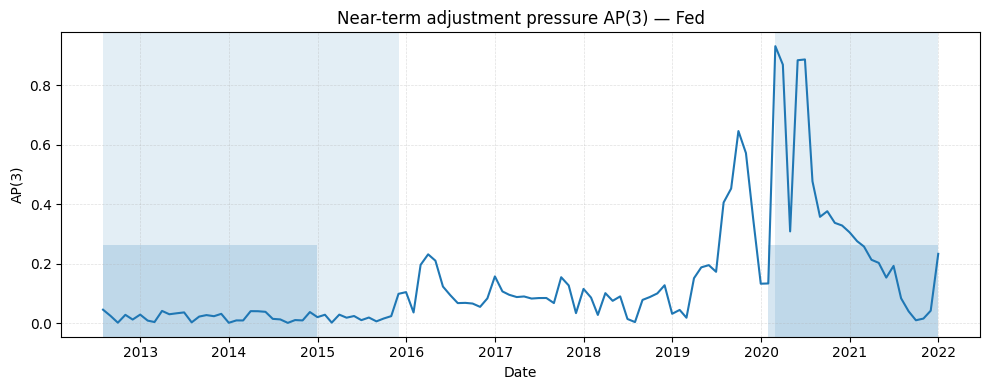

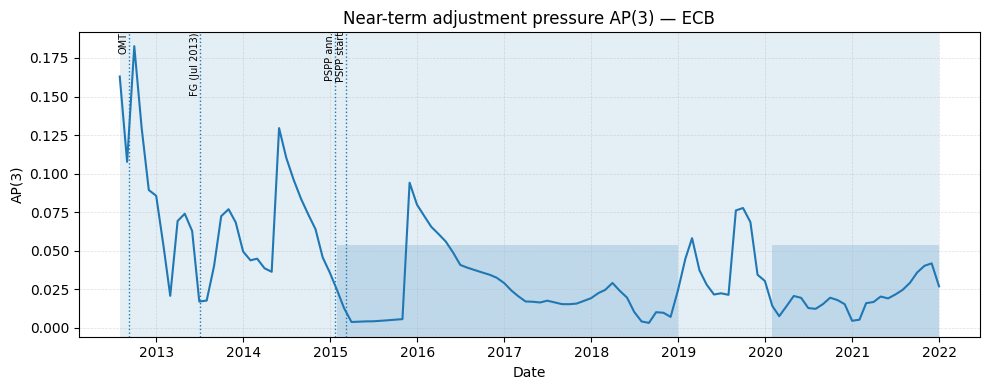

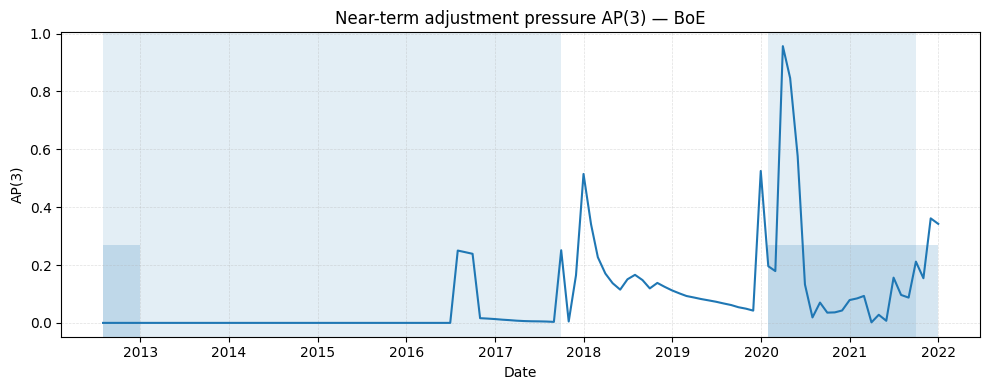


AP(3) descriptives by bank × ELB regime
bank  ELB     mean       sd      p25      p50      p75
 BoE    0 0.160210 0.130236 0.078858 0.121964 0.165717
 BoE    1 0.059745 0.159577 0.000000 0.000000 0.029868
 ECB    1 0.038294 0.033822 0.016353 0.024499 0.051910
 Fed    0 0.137880 0.132369 0.069638 0.094540 0.153438
 Fed    1 0.135677 0.229305 0.013618 0.028995 0.194934


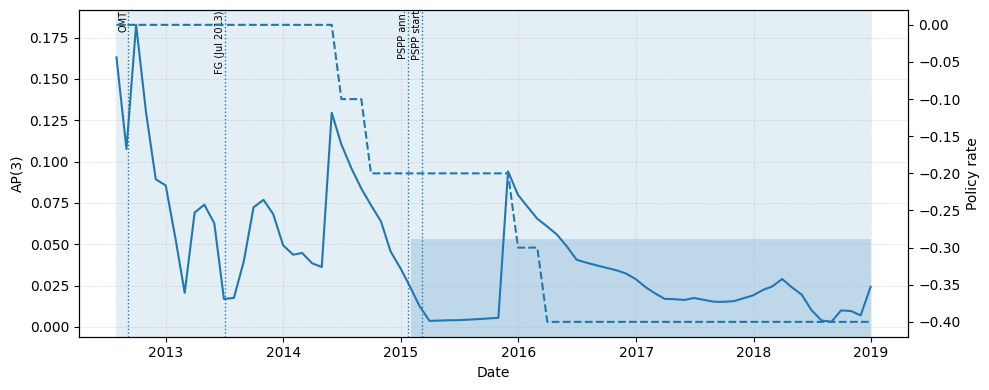


ECB AP(3) case-study windows (OMT / PSPP / FG)
                 window      start        end  mean_AP3   sd_AP3      p25      p50      p75  n
             OMT window 2011-10-01 2013-04-30  0.097430 0.049603 0.070403 0.087450 0.124074 10
Pre-PSPP / disinflation 2014-01-01 2015-02-28  0.059841 0.034325 0.036832 0.045214 0.081180 14
             Early PSPP 2015-03-01 2016-12-31  0.034593 0.028168 0.004889 0.035088 0.054066 22
      Late PSPP / taper 2017-01-01 2018-12-31  0.016623 0.006661 0.013980 0.016910 0.020940 24


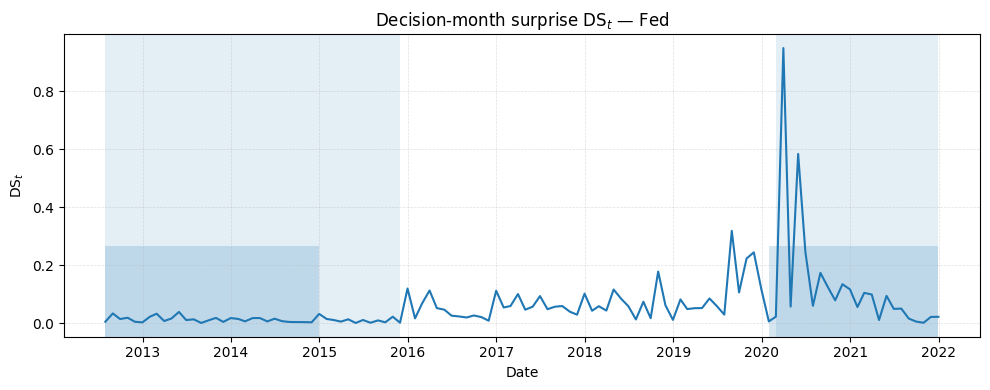

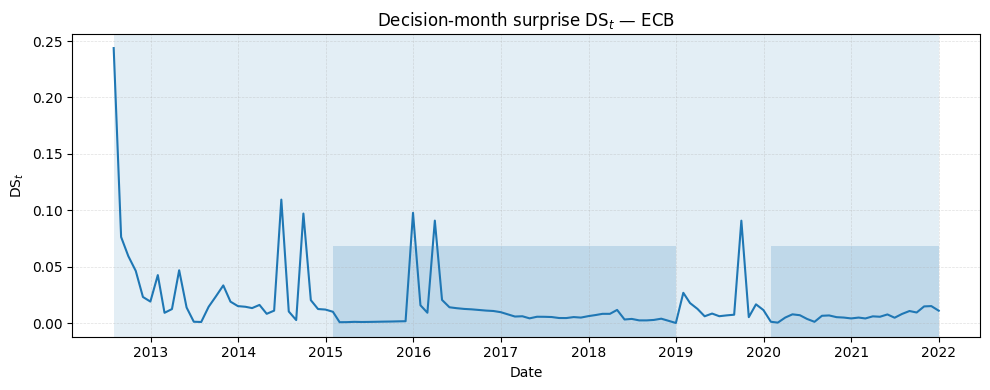

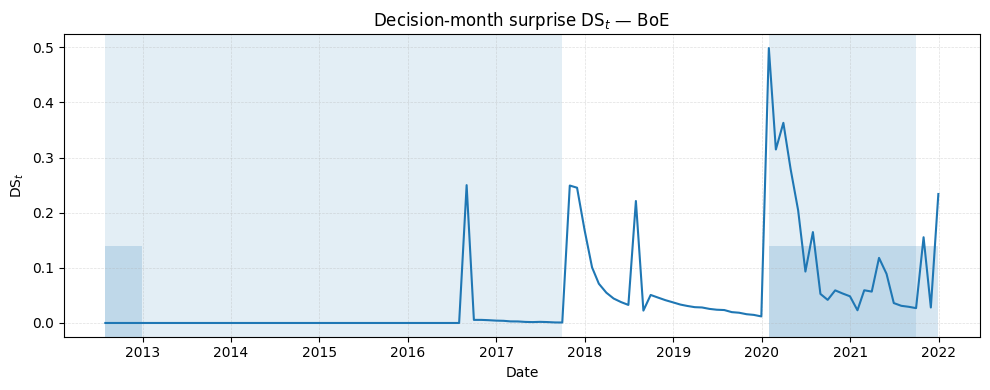


DS_t descriptives by bank × ELB regime
bank  ELB     mean       sd      p25      p50      p75
 BoE    0 0.070551 0.076084 0.024413 0.035378 0.067147
 BoE    1 0.034909 0.087896 0.000000 0.000000 0.024023
 ECB    1 0.016718 0.030157 0.004784 0.008246 0.014274
 Fed    0 0.071127 0.061149 0.031645 0.056494 0.090903
 Fed    1 0.055335 0.140426 0.005422 0.015152 0.040912

Correlation between DS_t and AP(3) by bank
bank  corr_DS_AP3   n
 BoE     0.614831 114
 ECB     0.659873 114
 Fed     0.697977 114


In [6]:
import matplotlib.pyplot as plt

mon_ap = to_monthly_panel(elb_eps=ELB_EPS, rho=RHO_DEFAULT, elb_mode="data_driven")
mon_ap = mon_ap.sort_values(["bank", "date"]).copy()

best_w_ap = cv_select_rf_window_rt(mon_ap)

rf_ap = estimate_reaction_function_realtime(mon_ap, window=best_w_ap)
mon_ap = merge_no_overlap(mon_ap, rf_ap, on=["bank", "date"], suffix="_rf", validate="one_to_one")

for c in ["di_hat_rt", "di_surpr_rt"]:
    if f"{c}_rf" in mon_ap.columns:
        mon_ap[c] = mon_ap[f"{c}_rf"]

mon_ap["AP3"] = (
    mon_ap
    .sort_values(["bank", "date"])
    .groupby("bank")["di_surpr_rt"]
    .transform(lambda s: s.shift(-1).rolling(3, min_periods=3).sum().abs())
)

mon_ap["DS"] = mon_ap["di_surpr_rt"].abs()

mon_ap = mon_ap.dropna(subset=["AP3", "DS"]).sort_values(["bank", "date"]).copy()

def shade_regime(ax, dates, flag, ymin=0.0, ymax=1.0, alpha=0.15):
    """
    Σκιασμός συνεχόμενων διαστημάτων όπου flag == 1.
    Δεν ορίζει explicit χρώμα (συμβατό με journal-neutral look).
    """
    in_seg = False
    start = None
    for t, (dt, f) in enumerate(zip(dates, flag)):
        if f and not in_seg:
            in_seg = True
            start = dt
        elif (not f) and in_seg:
            ax.axvspan(start, dates.iloc[t-1], ymin=ymin, ymax=ymax, alpha=alpha)
            in_seg = False
    if in_seg:
        ax.axvspan(start, dates.iloc[-1], ymin=ymin, ymax=ymax, alpha=alpha)

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

for b in ["Fed", "ECB", "BoE"]:
    g = mon_ap[mon_ap["bank"] == b].dropna(subset=["AP3"]).copy()
    if g.empty:
        continue

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(g["date"], g["AP3"], label="AP(3)")

    elb_flag = g["ELB"].fillna(0).astype(int)
    shade_regime(ax, g["date"], elb_flag, ymin=0.0, ymax=1.0, alpha=0.12)

    qe_flag = g["QE_FG"].fillna(0).astype(int)
    shade_regime(ax, g["date"], qe_flag, ymin=0.0, ymax=0.30, alpha=0.18)

    if b == "ECB":
        ecb_events = {
            "Draghi WIT":   pd.Timestamp("2012-07-26"),
            "OMT":          pd.Timestamp("2012-09-06"),
            "FG (Jul 2013)": pd.Timestamp("2013-07-04"),
            "PSPP ann.":    pd.Timestamp("2015-01-22"),
            "PSPP start":   pd.Timestamp("2015-03-09"),
        }
        y_top = ax.get_ylim()[1]
        for label, dt_ev in ecb_events.items():
            if g["date"].min() <= dt_ev <= g["date"].max():
                ax.axvline(dt_ev, linestyle=":", linewidth=1.0)
                ax.text(dt_ev, y_top, label, rotation=90,
                        va="top", ha="right", fontsize=7)

    ax.set_title(f"Near-term adjustment pressure AP(3) — {b}")
    ax.set_xlabel("Date")
    ax.set_ylabel("AP(3)")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    fig.tight_layout()

    if SAVE_FILES:
        fig.savefig(_p(f"fig_AP3_timeseries_{b}.pdf"))
    plt.show()

ap_stats = (
    mon_ap
    .dropna(subset=["AP3", "ELB"])
    .groupby(["bank", "ELB"])["AP3"]
    .agg(mean="mean",
         sd="std",
         p25=q25,
         p50="median",
         p75=q75)
    .reset_index()
    .sort_values(["bank", "ELB"])
)

print("\nAP(3) descriptives by bank × ELB regime")
print(ap_stats.to_string(index=False))

if SAVE_FILES:
    ap_stats.to_latex(
        _p("table_AP3_descriptives_by_bank_ELB.tex"),
        index=False,
        float_format="%.3f"
    )

ecb_cs = mon_ap[
    (mon_ap["bank"] == "ECB") &
    (mon_ap["date"] >= pd.Timestamp("2012-01-01")) &
    (mon_ap["date"] <= pd.Timestamp("2018-12-31"))
].dropna(subset=["AP3"]).copy()

if not ecb_cs.empty:
    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax1.plot(ecb_cs["date"], ecb_cs["AP3"], label="AP(3)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("AP(3)")

    shade_regime(ax1, ecb_cs["date"], ecb_cs["ELB"].fillna(0).astype(int),
                 ymin=0.0, ymax=1.0, alpha=0.12)
    shade_regime(ax1, ecb_cs["date"], ecb_cs["QE_FG"].fillna(0).astype(int),
                 ymin=0.0, ymax=0.30, alpha=0.18)

    ax2 = ax1.twinx()
    ax2.plot(ecb_cs["date"], ecb_cs["policy_rate"], linestyle="--")
    ax2.set_ylabel("Policy rate")

    ecb_events = {
        "Draghi WIT":    pd.Timestamp("2012-07-26"),
        "OMT":           pd.Timestamp("2012-09-06"),
        "FG (Jul 2013)": pd.Timestamp("2013-07-04"),
        "PSPP ann.":     pd.Timestamp("2015-01-22"),
        "PSPP start":    pd.Timestamp("2015-03-09"),
    }
    y_top = ax1.get_ylim()[1]
    for label, dt_ev in ecb_events.items():
        if ecb_cs["date"].min() <= dt_ev <= ecb_cs["date"].max():
            ax1.axvline(dt_ev, linestyle=":", linewidth=1.0)
            ax1.text(dt_ev, y_top, label, rotation=90,
                     va="top", ha="right", fontsize=7)

    ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    fig.tight_layout()

    if SAVE_FILES:
        fig.savefig(_p("fig_AP3_ECB_case_study_2012_2018.pdf"))
    plt.show()

    case_windows = {
        "OMT window": (
            pd.Timestamp("2011-10-01"),
            pd.Timestamp("2013-04-30")
        ),
        "Pre-PSPP / disinflation": (
            pd.Timestamp("2014-01-01"),
            pd.Timestamp("2015-02-28")
        ),
        "Early PSPP": (
            pd.Timestamp("2015-03-01"),
            pd.Timestamp("2016-12-31")
        ),
        "Late PSPP / taper": (
            pd.Timestamp("2017-01-01"),
            pd.Timestamp("2018-12-31")
        ),
    }

    rows = []
    for label, (start, end) in case_windows.items():
        m = ecb_cs[(ecb_cs["date"] >= start) & (ecb_cs["date"] <= end)]["AP3"]
        rows.append({
            "window": label,
            "start": start.date(),
            "end": end.date(),
            "mean_AP3": m.mean(),
            "sd_AP3": m.std(ddof=1),
            "p25": m.quantile(0.25) if not m.empty else float("nan"),
            "p50": m.quantile(0.50) if not m.empty else float("nan"),
            "p75": m.quantile(0.75) if not m.empty else float("nan"),
            "n": m.count()
        })

    ecb_case_table = pd.DataFrame(rows)
    print("\nECB AP(3) case-study windows (OMT / PSPP / FG)")
    print(ecb_case_table.to_string(index=False))

    if SAVE_FILES:
        ecb_case_table.to_latex(
            _p("table_AP3_ECB_case_study_windows.tex"),
            index=False,
            float_format="%.3f"
        )
else:
    print("\n[ECB case study] No AP(3) observations for requested window.")

for b in ["Fed", "ECB", "BoE"]:
    g = mon_ap[mon_ap["bank"] == b].dropna(subset=["DS"]).copy()
    if g.empty:
        continue

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(g["date"], g["DS"], label="DS$_t$")

    elb_flag = g["ELB"].fillna(0).astype(int)
    shade_regime(ax, g["date"], elb_flag, ymin=0.0, ymax=1.0, alpha=0.12)

    qe_flag = g["QE_FG"].fillna(0).astype(int)
    shade_regime(ax, g["date"], qe_flag, ymin=0.0, ymax=0.30, alpha=0.18)

    ax.set_title(f"Decision-month surprise DS$_t$ — {b}")
    ax.set_xlabel("Date")
    ax.set_ylabel("DS$_t$")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    fig.tight_layout()

    if SAVE_FILES:
        fig.savefig(_p(f"fig_DS_timeseries_{b}.pdf"))
    plt.show()

ds_stats = (
    mon_ap
    .dropna(subset=["DS", "ELB"])
    .groupby(["bank", "ELB"])["DS"]
    .agg(mean="mean",
         sd="std",
         p25=q25,
         p50="median",
         p75=q75)
    .reset_index()
    .sort_values(["bank", "ELB"])
)

print("\nDS_t descriptives by bank × ELB regime")
print(ds_stats.to_string(index=False))

if SAVE_FILES:
    ds_stats.to_latex(
        _p("table_DS_descriptives_by_bank_ELB.tex"),
        index=False,
        float_format="%.3f"
    )

corr_rows = []
tmp = mon_ap.dropna(subset=["DS", "AP3"]).copy()
for b, g in tmp.groupby("bank"):
    if g.shape[0] >= 10:
        rho = g["DS"].corr(g["AP3"])
    else:
        rho = float("nan")
    corr_rows.append({"bank": b, "corr_DS_AP3": rho, "n": g.shape[0]})

corr_table = pd.DataFrame(corr_rows)
print("\nCorrelation between DS_t and AP(3) by bank")
print(corr_table.to_string(index=False))

if SAVE_FILES:
    corr_table.to_latex(
        _p("table_corr_DS_AP3_by_bank.tex"),
        index=False,
        float_format="%.3f"
    )